In [5]:
park_path = "/content/drive/MyDrive/Parkinson/parkinsons_updrs.data"

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

In [37]:
data = pd.read_csv(park_path)

In [8]:
data.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


#Male female

In [9]:
m = data[data['sex'] == 0].drop(columns=['subject#', 'sex']).reset_index(drop=True)
f = data[data['sex'] == 1].drop(columns=['subject#', 'sex']).reset_index(drop=True)

In [10]:
m_corr = m.corr()
f_corr = f.corr()

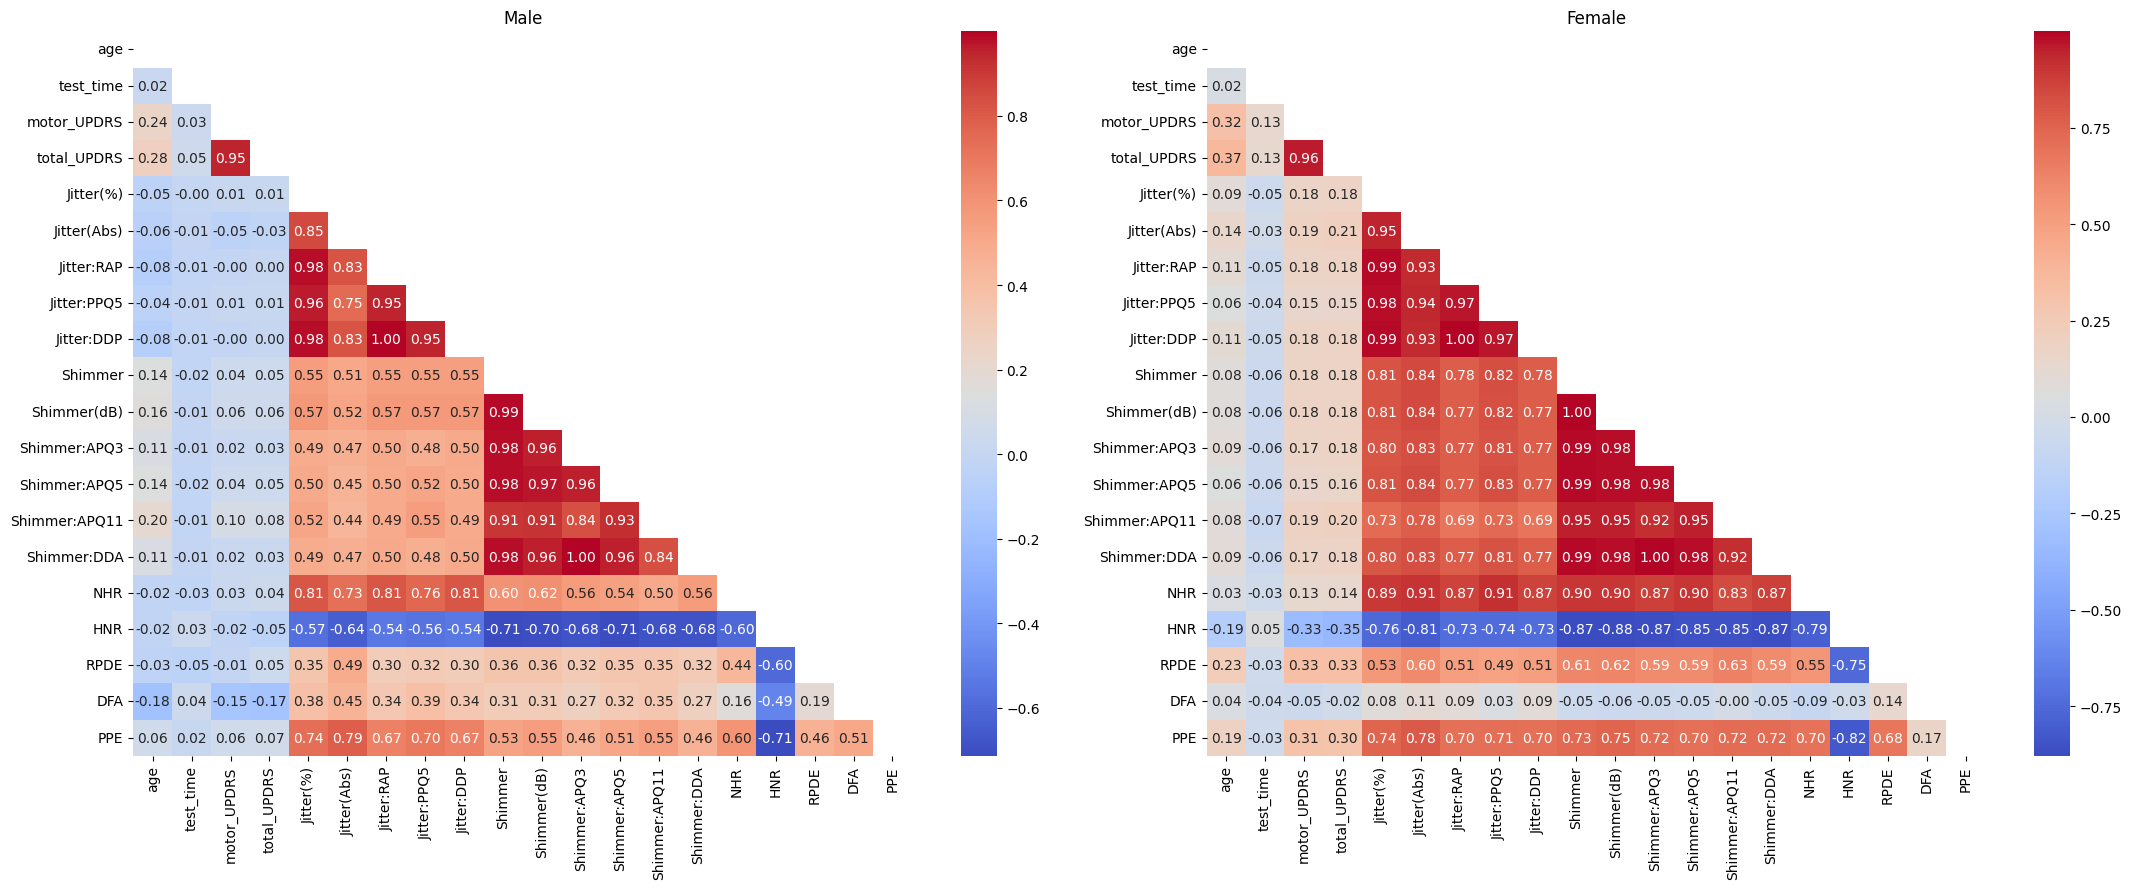

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(22, 9))
mmask = np.triu(np.ones_like(m_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(m_corr,annot=True, cmap='coolwarm', fmt=".2f", mask=mmask, ax=ax[0])
ax[0].set_title("Male")

fmask = np.triu(np.ones_like(f_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(f_corr,annot=True, cmap='coolwarm', fmt=".2f", mask=fmask, ax=ax[1])
ax[1].set_title("Female")

plt.tight_layout()
plt.show()

#PCA

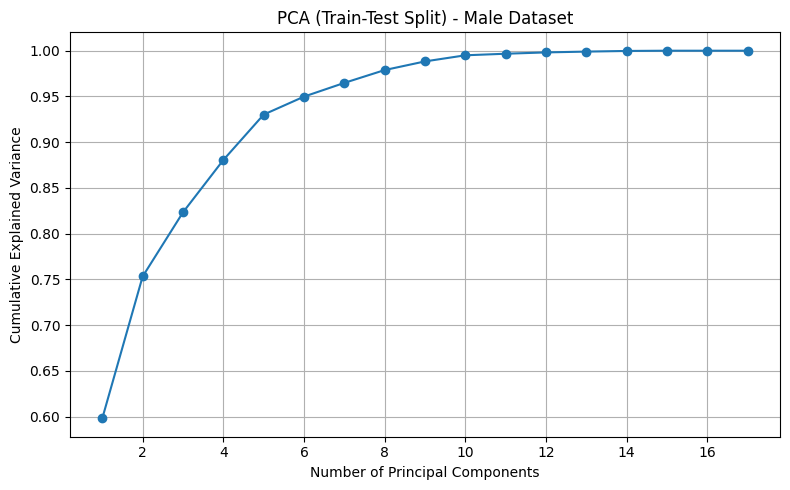

np.int64(9)

In [11]:
X_male_raw = m.drop(columns=['test_time', 'motor_UPDRS', 'total_UPDRS']).values
y_male = m['total_UPDRS'].values

X_male_train_raw, X_male_test_raw, y_male_train ,y_male_test = train_test_split(X_male_raw,y_male, test_size=0.2, random_state=42)

scaler_male = StandardScaler()
X_male_train_scaled = scaler_male.fit_transform(X_male_train_raw)
X_male_test_scaled = scaler_male.transform(X_male_test_raw)

pca_male_corrected = PCA()
X_male_train_pca = pca_male_corrected.fit_transform(X_male_train_scaled)

cumulative_variance_male = pca_male_corrected.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_male) + 1), cumulative_variance_male, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA (Train-Test Split) - Male Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

n_components_95 = (cumulative_variance_male >= 0.98).argmax() + 1
n_components_95


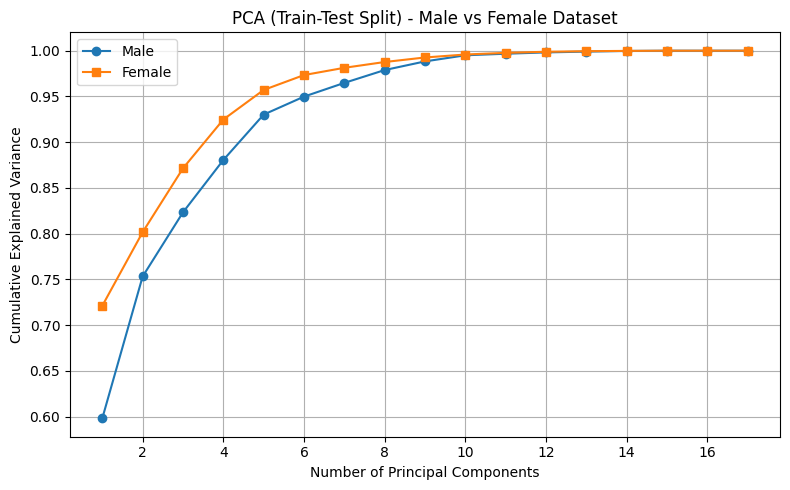

In [12]:
X_female_raw = f.drop(columns=['test_time', 'motor_UPDRS', 'total_UPDRS']).values
y_female = f['total_UPDRS'].values

X_female_train_raw, X_female_test_raw, y_female_train, y_female_test = train_test_split(X_female_raw, y_female, test_size=0.2, random_state=42)

scaler_female = StandardScaler()
X_female_train_scaled = scaler_female.fit_transform(X_female_train_raw)
X_female_test_scaled = scaler_female.transform(X_female_test_raw)

pca_female_corrected = PCA()
X_female_train_pca = pca_female_corrected.fit_transform(X_female_train_scaled)

cumulative_variance_female = pca_female_corrected.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_male) + 1), cumulative_variance_male, marker='o', label='Male')
plt.plot(range(1, len(cumulative_variance_female) + 1), cumulative_variance_female, marker='s', label='Female')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA (Train-Test Split) - Male vs Female Dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
n_components_95 = (cumulative_variance_female >= 0.98).argmax() + 1
n_components_95

np.int64(9)

#Regression

In [17]:
def run_pca_model(df_group, target_column, n_components):
    X = df_group.drop(columns=['subject#', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS']).values
    y = df_group[target_column].values

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
    }

In [18]:
df_m = data[data['sex'] == 1]
df_f = data[data['sex'] == 0]

results = {
    'Male - Total UPDRS': run_pca_model(df_m, 'total_UPDRS', 8),
    'Male - Motor UPDRS': run_pca_model(df_m, 'motor_UPDRS', 8),
    'Female - Total UPDRS': run_pca_model(df_f, 'total_UPDRS', 9),
    'Female - Motor UPDRS': run_pca_model(df_f, 'motor_UPDRS', 9),
}
results

{'Male - Total UPDRS': {'coefficients': array([ 0.63518774,  0.79372861,  3.1855923 ,  2.14518232,  1.73673037,
          0.97274256, -3.43504419, -3.28780726]),
  'intercept': np.float64(27.441903081044874),
  'RMSE': np.float64(8.216548978033401),
  'MAE': 6.477089869940478,
  'R2': 0.28405843221504345},
 'Male - Motor UPDRS': {'coefficients': array([ 0.54162337,  0.50679508,  2.5174969 ,  1.71525485,  2.07582477,
          1.06174852, -3.0186904 , -1.0133434 ]),
  'intercept': np.float64(20.808399866041526),
  'RMSE': np.float64(7.321501720545059),
  'MAE': 5.893900879260789,
  'R2': 0.24401379795727218},
 'Female - Total UPDRS': {'coefficients': array([ 0.0660324 ,  0.45968265, -1.5908951 ,  2.83276614,  0.37906682,
         -0.45554236,  2.77649124, -0.28413312, -0.73422998]),
  'intercept': np.float64(29.649652557704304),
  'RMSE': np.float64(10.668212646670453),
  'MAE': 8.85640900249848,
  'R2': 0.1439822929731327},
 'Female - Motor UPDRS': {'coefficients': array([ 0.02003455, 

#Visualization

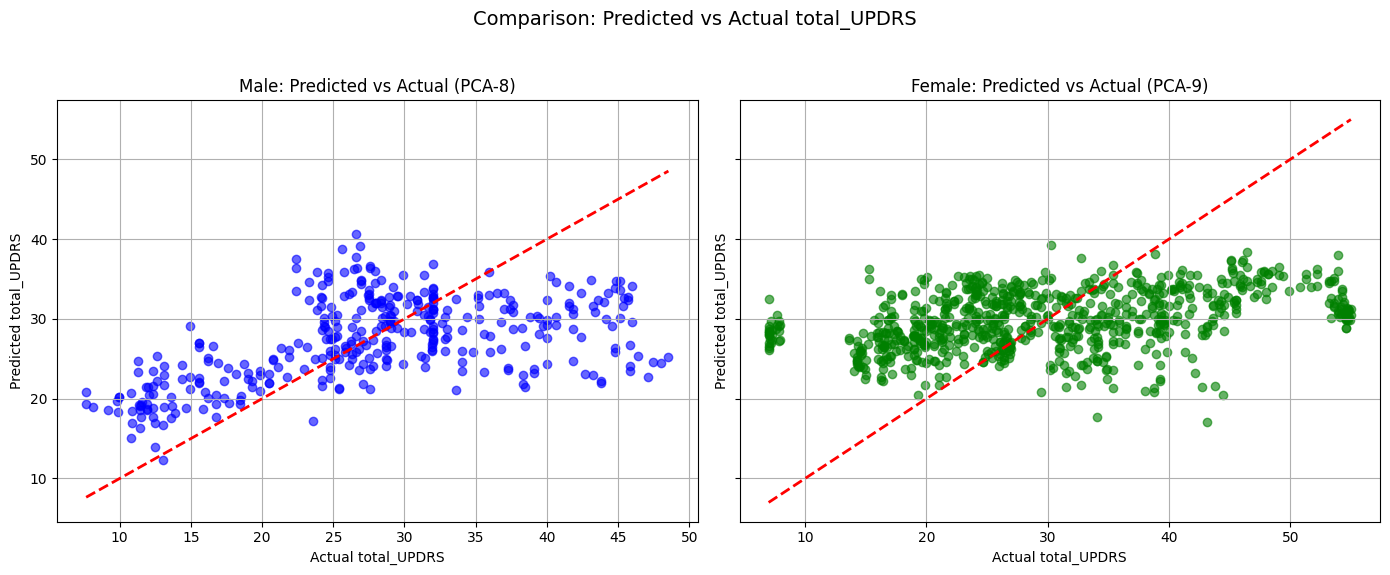

In [21]:
def get_preds(df_group, target_column, n_components):
    features = df_group.drop(columns=['subject#', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS']).values
    target = df_group[target_column].values

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)

    return {"y_test": y_test, "y_pred": y_pred}

male_result = get_preds(df_m, 'total_UPDRS', 8)
female_result = get_preds(df_f, 'total_UPDRS', 9)


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, result, title, color in zip(
    axes,
    [male_result, female_result],
    ['Male: Predicted vs Actual (PCA-8)', 'Female: Predicted vs Actual (PCA-9)'],
    ['blue', 'green']
):
    y_test, y_pred = result["y_test"], result["y_pred"]
    ax.scatter(y_test, y_pred, alpha=0.6, color=color)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_title(title)
    ax.set_xlabel("Actual total_UPDRS")
    ax.set_ylabel("Predicted total_UPDRS")
    ax.grid(True)

plt.suptitle('Comparison: Predicted vs Actual total_UPDRS', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


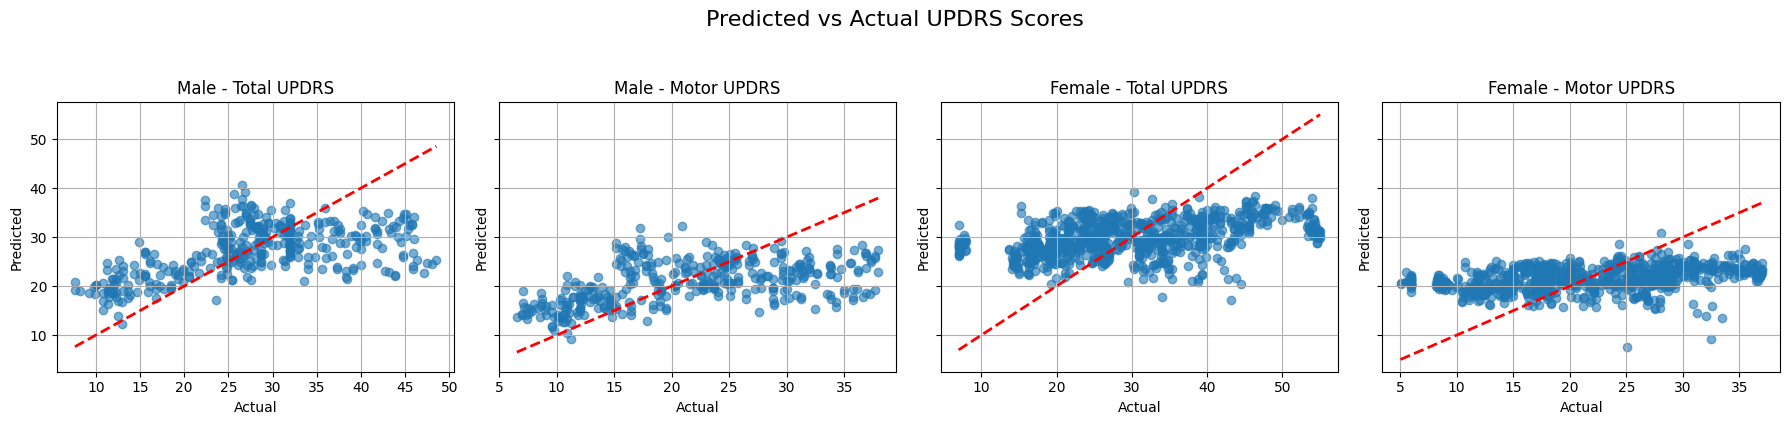

In [22]:
all_model_outputs = {
    "Male - Total UPDRS": get_preds(df_m, 'total_UPDRS', 8),
    "Male - Motor UPDRS": get_preds(df_m, 'motor_UPDRS', 8),
    "Female - Total UPDRS": get_preds(df_f, 'total_UPDRS', 9),
    "Female - Motor UPDRS": get_preds(df_f, 'motor_UPDRS', 9)
}

fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

for ax, (title, result) in zip(axes, all_model_outputs.items()):
    y_test = result['y_test']
    y_pred = result['y_pred']
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_title(title)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.grid(True)

plt.suptitle("Predicted vs Actual UPDRS Scores", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [23]:
X = data.drop(columns=['subject#', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS']).values
y_total = data['total_UPDRS'].values
y_motor = data['motor_UPDRS'].values

X_train_raw, X_test_raw, y_total_train, y_total_test, y_motor_train, y_motor_test = train_test_split(
    X, y_total, y_motor, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components = (cumulative_variance >= 0.975).argmax() + 1
print(f"Number of PCA components to retain ~97.5% variance: {n_components}")

X_train_reduced = X_train_pca[:, :n_components]
X_test_reduced = X_test_pca[:, :n_components]

model_total = LinearRegression().fit(X_train_reduced, y_total_train)
y_total_pred = model_total.predict(X_test_reduced)
rmse_total = np.sqrt(mean_squared_error(y_total_test, y_total_pred))
r2_total = r2_score(y_total_test, y_total_pred)

model_motor = LinearRegression().fit(X_train_reduced, y_motor_train)
y_motor_pred = model_motor.predict(X_test_reduced)
rmse_motor = np.sqrt(mean_squared_error(y_motor_test, y_motor_pred))
r2_motor = r2_score(y_motor_test, y_motor_pred)

print(f"Total UPDRS: RMSE = {rmse_total:.2f}, R² = {r2_total:.3f}")
print(f"Motor UPDRS: RMSE = {rmse_motor:.2f}, R² = {r2_motor:.3f}")

Number of PCA components to retain ~97.5% variance: 8
Total UPDRS: RMSE = 9.85, R² = 0.124
Motor UPDRS: RMSE = 7.63, R² = 0.089


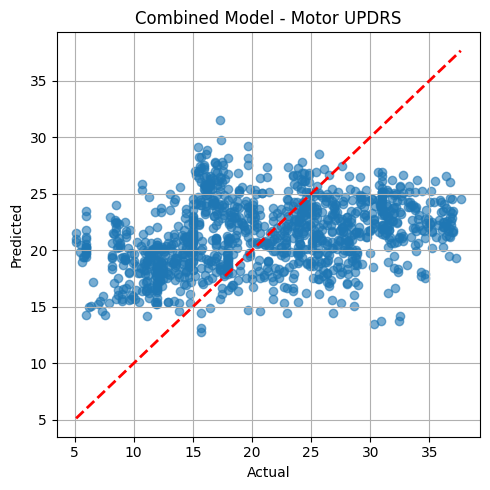

In [24]:
plt.figure(figsize=(5, 5))

plt.scatter(y_motor_test, y_motor_pred, alpha=0.6)
plt.plot(
    [y_motor_test.min(), y_motor_test.max()],
    [y_motor_test.min(), y_motor_test.max()],
    'r--', lw=2
)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Combined Model - Motor UPDRS")
plt.grid(True)
plt.tight_layout()
plt.show()


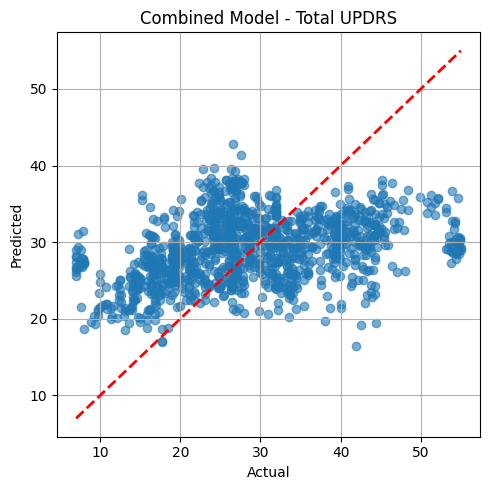

In [25]:
plt.figure(figsize=(5, 5))
plt.scatter(y_total_test, y_total_pred, alpha=0.6)
plt.plot(
    [y_total_test.min(), y_total_test.max()],
    [y_total_test.min(), y_total_test.max()],
    'r--', lw=2
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.title("Combined Model - Total UPDRS")
plt.tight_layout()
plt.show()


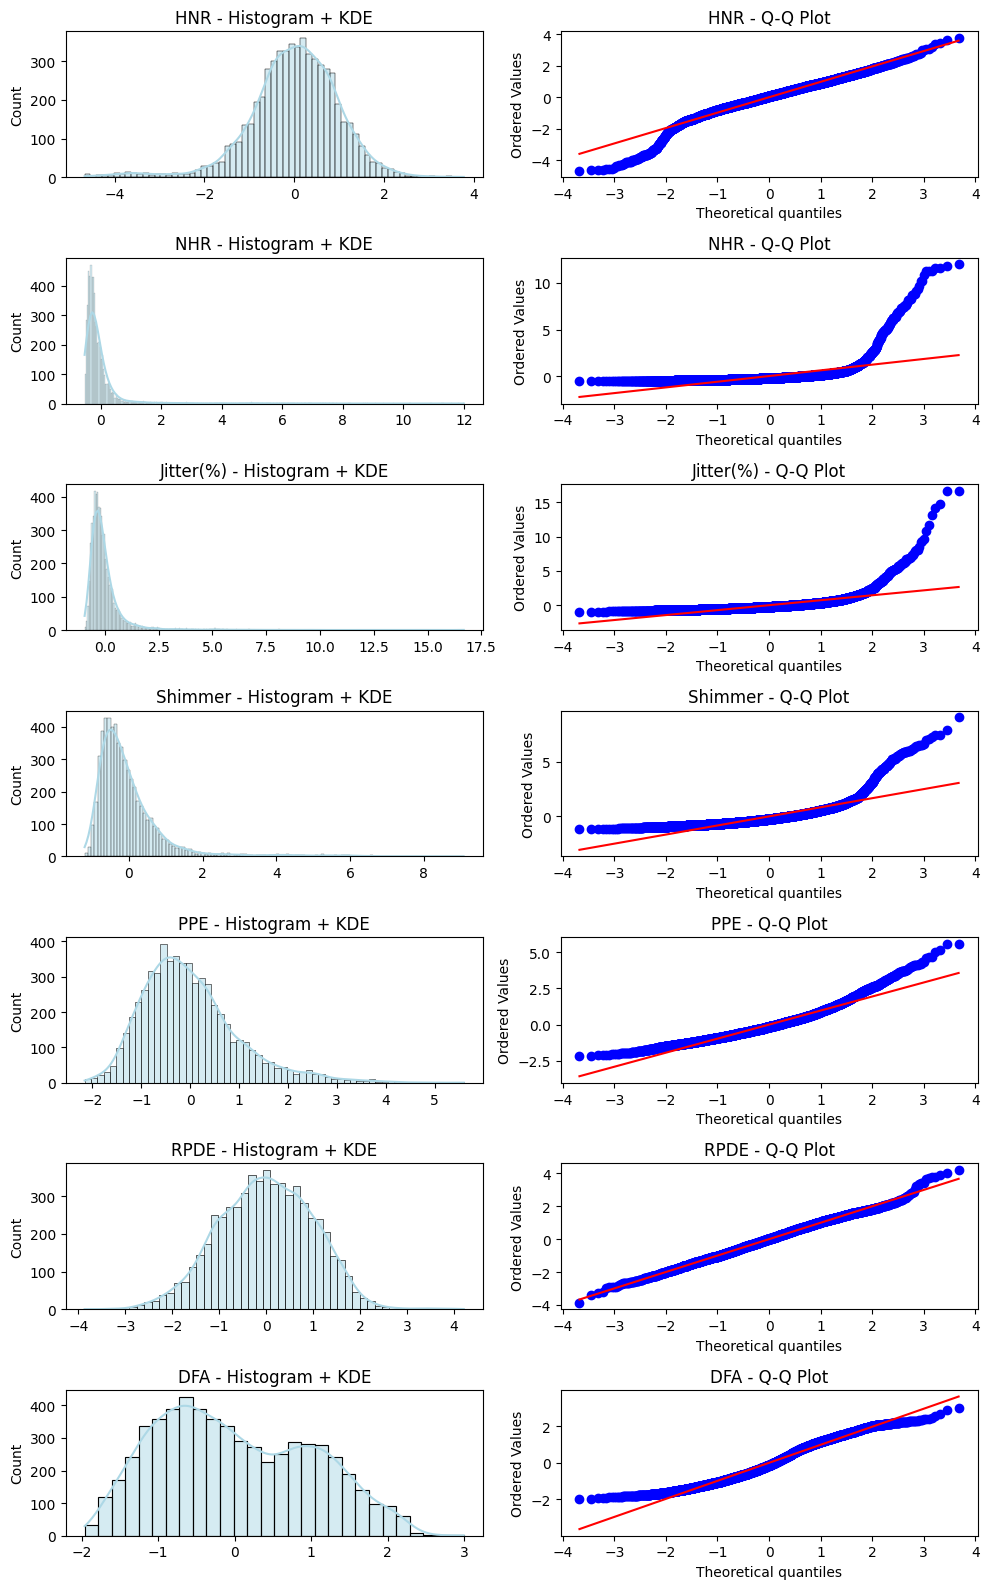

In [34]:
features_to_check = ['HNR', 'NHR', 'Jitter(%)', 'Shimmer', 'PPE', 'RPDE', 'DFA']

selected_data_v2 = data[features_to_check]
scaled_data_v2 = StandardScaler().fit_transform(selected_data_v2)

fig, axes = plt.subplots(len(features_to_check), 2, figsize=(10, 16))

for i, feature in enumerate(features_to_check):
    data = scaled_data_v2[:, i]
    sns.histplot(data, kde=True, ax=axes[i, 0], color='lightblue')
    axes[i, 0].set_title(f'{feature} - Histogram + KDE')

    stats.probplot(data, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'{feature} - Q-Q Plot')

plt.tight_layout()
plt.show()

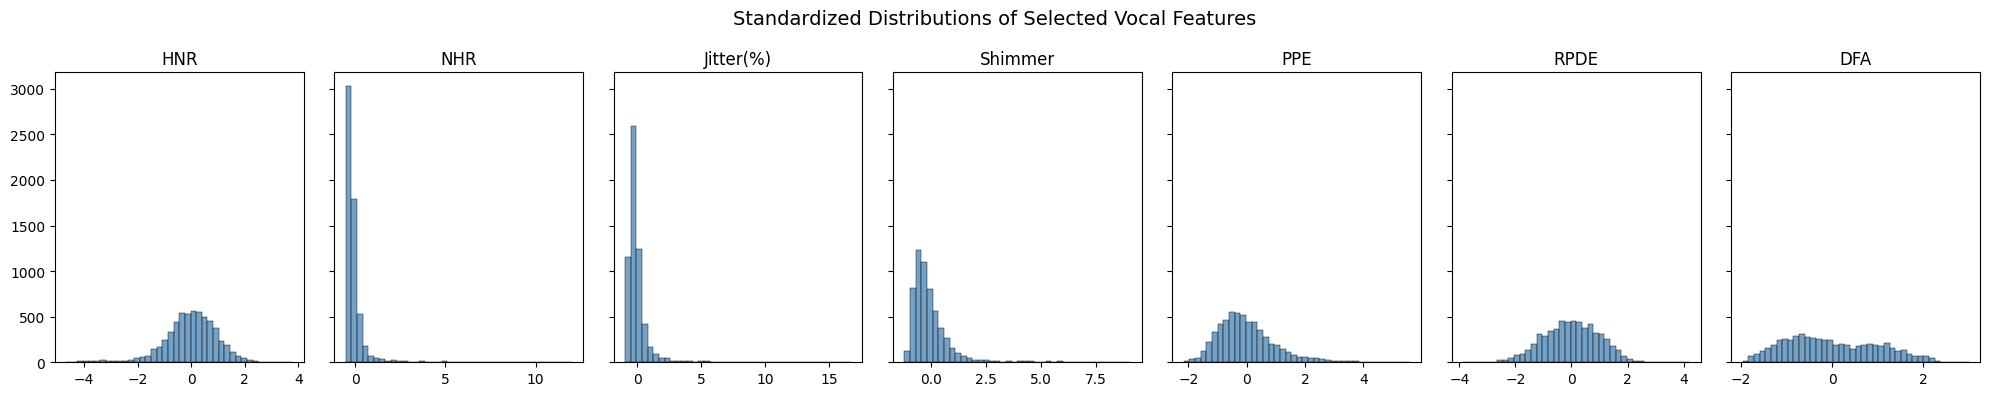

In [39]:
fig, axes = plt.subplots(1, len(features_to_check), figsize=(20, 4), sharey=True)

for i, feature in enumerate(features_to_check):
    sns.histplot(scaled_data_v2[:, i], bins=40, ax=axes[i], color='steelblue')
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.suptitle('Standardized Distributions of Selected Vocal Features', fontsize=14)
plt.tight_layout()
plt.show()


In [47]:
final_causal_features = ['HNR', 'NHR', 'Jitter(%)', 'Shimmer', 'PPE', 'RPDE', 'DFA']
confounders = ['age', 'sex', 'test_time']
outcome = 'total_UPDRS'

def run_ipw_causal_inference(df, feature, confounders, outcome):
    df_temp = df.copy()
    df_temp['binary_treatment'] = (df_temp[feature] > df_temp[feature].median()).astype(int)
    ps_model = LogisticRegression()
    X_conf_scaled = StandardScaler().fit_transform(df_temp[confounders])
    ps_model.fit(X_conf_scaled, df_temp['binary_treatment'])
    ps_scores = ps_model.predict_proba(X_conf_scaled)[:, 1]
    treatment = df_temp['binary_treatment']
    weights = np.where(treatment == 1, 1 / ps_scores, 1 / (1 - ps_scores))
    X = sm.add_constant(treatment)
    y = df_temp[outcome]
    model = sm.WLS(y, X, weights=weights).fit()
    return {
        'Feature': feature,
        'ATE': model.params['binary_treatment'],
        'p-value': model.pvalues['binary_treatment'],
        '95% CI Lower': model.conf_int().loc['binary_treatment', 0],
        '95% CI Upper': model.conf_int().loc['binary_treatment', 1]
    }

causal_results_final_df = pd.DataFrame([
    run_ipw_causal_inference(data, f, confounders, outcome) for f in final_causal_features
]).round(4)

causal_results_final_df


,Feature,ATE,p-value,95% CI Lower,95% CI Upper
0,HNR,-2.6103,0.0000,-3.1454,-2.0751
1,NHR,1.0845,0.0001,0.5361,1.6328
2,Jitter(%),1.3708,0.0000,0.8293,1.9122
3,Shimmer,1.2712,0.0000,0.7322,1.8102
4,PPE,2.3832,0.0000,1.8472,2.9192
5,RPDE,1.5483,0.0000,1.0014,2.0952
6,DFA,-1.1973,0.0000,-1.7476,-0.6471
